Reference: [Ultralytics YoloV5 github repository](https://github.com/ultralytics/yolov5)

# Imports

In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests #to download some data from internet
import random
import numpy as np

SEED = 42
np.random.seed(SEED)

In [2]:
!ls
!pwd

data_full.yaml
dataset
dataset_full
dataset_full.zip
dataset_heartmet
dataset_heartmet_day_2
dataset_heartmet_day_2.yaml
dataset_heartmet_day_2.zip
dataset_heartmet_day_3
dataset_heartmet_day_3.yaml
dataset_heartmet_day_3.zip
dataset_heartmet.yaml
dataset_ss22
dataset_ss22_inference
dataset_ss22_inference.zip
dataset_ss22_v0
dataset_ss22_v2
dataset_ss22_v2.yaml
dataset_ss22_v2.zip
dataset_ss22_v3
dataset_ss22_v3.yaml
dataset_ss22_v3.zip
dataset_ss22_v4
dataset_ss22_v4.yaml
dataset_ss22_v4.zip
dataset_ss22.yaml
dataset_ss22.zip
dataset.zip
data.yaml
day3_test_images
day3_test_images.zip
extreme_all_20_obj.jpeg
inference_heartmet_set_2
inference_heartmet_set_2.zip
inference_images
inference_images.zip
object_recognition_YOLOv5_heartmet.ipynb
object_recognition_YOLOv5.ipynb
object_recognition_YOLOv_ss22_local_competition.ipynb
test_bounding_box
test_yolo
training_logs_ss22.txt
YOLODataset.zip
yolov5
/home/jovyan/public/b_it_bot_work/2d_perception


## Prepare the Dataset


Dataset for HEART-MET 2022 competition Source: ADD

The dataset is structured in the following manner:

```
├── dataset_heartmet.yaml
├── README.md
├── dataset
        test
        ├── images
        └── labels
        train
        ├── images
        └── labels
        valid
        ├── images
        └── labels

```

### The Dataset YAML File

The dataset YAML (`dataset_heartmet.yaml`) file containing the path to the training and validation images and labels. This file will also contain the class names from the dataset.

The dataset contains 20 classes.

The following block shows the contents of the `dataset_heartmet.yaml` file.

```yaml
train: ../dataset_heartmet/train/images
val: ../dataset_heartmet/valid/images

nc: 17

names: ['cup', 'plate', 'bowl', 'towel', 'shoes', 'sponge', 'bottle', 'toothbrush', 'toothpaste', 'tray', 'sweater', 'medicine bottle', 'reading glasses', 'flashlight', 'pill box', 'book', 'basket']
```

### Visualize a Few Ground Truth Images

In YOLO format, [x_center, y_center, width, height]


```
A------------------------
-------------------------
-------------------------
-------------------------
-------------------------
------------------------B
```

In Bounding Box format, A [x_min, y_min] and B [x_max, y_max].


Visualize 4 random samples from Dataset

[Reference](https://www.youtube.com/watch?v=Ciy1J97dbY0&ab_channel=LearnOpenCV)

In [3]:
class_names = ['cup', 'plate', 'bowl', 'towel', 'shoes', 'sponge', 'bottle', 'toothbrush', 'toothpaste', 'tray', 'sweater', 
               'medicine bottle', 'reading glasses', 'flashlight', 'pill box', 'book', 'basket']

colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [4]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1, max(3, int(w/500)))
        font_thickness = min(2, max(10, int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [6]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images-1)
        # j = 0
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line.split(' ')[0]
                bbox_string = label_line.split(' ')[1:]
                x_c, y_c, w, h = bbox_string
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h.split('\n')[0])
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()


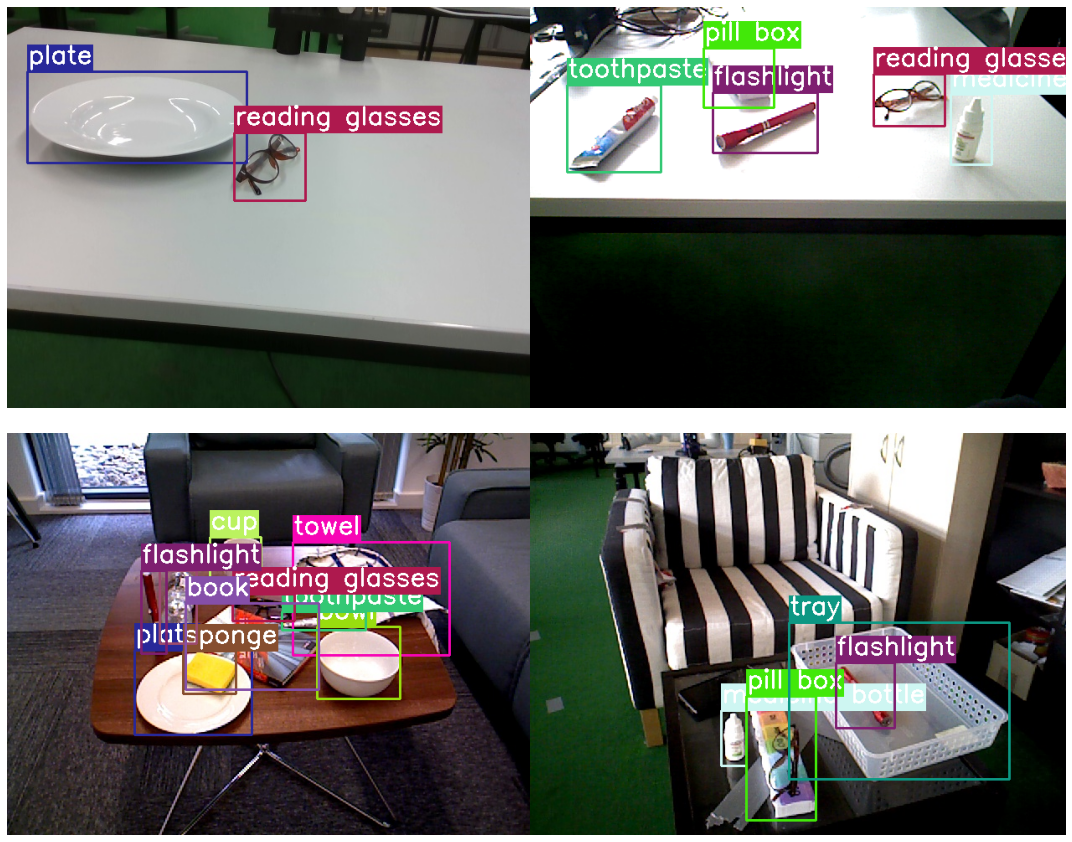

In [7]:
# Visualize a few training images.
plot(
    image_paths='dataset_heartmet_day_3/train/images/*', 
    label_paths='dataset_heartmet_day_3/train/labels/*',
    num_samples=4,
)

# plot(
#     image_paths='dataset_ss22_inference/train/images/*', 
#     label_paths='dataset_ss22_inference/train/labels/*',
#     num_samples=4,
# )

## Helper Functions for Logging

The helper functions are for logging of the results in the notebook while training the models.


In [8]:
def set_res_dir():
    # Directory to store results
    #res_dir_count = len(glob.glob('runs/train/*'))
    res_dir_count = len(glob.glob('/home/jovyan/public/logs/yolo5/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"/home/jovyan/public/logs/yolo5/train/results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"/home/jovyan/public/logs/yolo5/train/results_{res_dir_count}"
    return RES_DIR

## Clone YOLOV5 Repository

In [9]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [10]:
# Change to yoloV5 directory
%cd yolov5

/home/jovyan/public/b_it_bot_work/2d_perception/yolov5


## **Function to Monitor TensorBoard logs**

**NOTE**: TensorBoard logs can be visualized with [Local port link](http://10.20.118.78:31025/#scalars&runSelectionState=eyJ5b2xvNS90cmFpbi9yZXN1bHRzXzEiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzIiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzMiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzQiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzUiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzgiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzgyIjpmYWxzZSwieW9sbzUvdHJhaW4vcmVzdWx0c18xNCI6ZmFsc2UsInlvbG81L3RyYWluL3Jlc3VsdHNfMTMiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzEyIjpmYWxzZSwieW9sbzUvdHJhaW4vcmVzdWx0c18xMSI6ZmFsc2V9)


## Training using YOLOV5

In [11]:
TRAIN = False
FREEZE = True # freezing first 15 layers
EPOCHS = 1500

##### If already trained model (.pt file) is available, then give that model path in `--weights` argument

In [12]:

if TRAIN:
    
    '''
    Data augmentation: 
    - not applying Hue and Saturation, as our objects are color dependent 
    - fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
    - hsv_h: 0.0 # 0.015(Kevin: this is the default value)  # image HSV-Hue augmentation (fraction)
    - hsv_s: 0.0 # 0.7(Kevin: this is the default value) # image HSV-Saturation augmentation (fraction)
    - hsv_v: 0.4 # 0.4(Kevin: this is the default value) # image HSV-Value augmentation (fraction)
    - degrees: 0.0 # 0.0(Kevin: this is the default value) # image rotation (+/- deg)
    - translate: 0.1  # image translation (+/- fraction)
    - scale: 0.0 # 0.5(Kevin: this is the default value) # image scale (+/- gain)
    - shear: 0.0  # image shear (+/- deg)
    - perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
    - flipud: 0.5 # 0.0(Kevin: this is the default value) # image flip up-down (probability)
    - fliplr: 0.5  # image flip left-right (probability)
    - mosaic: 1.0  # image mosaic (probability)
    - mixup: 0.0  # image mixup (probability)
    - copy_paste: 0.0  # segment copy-paste (probability)
    '''
    
    if FREEZE:
        RES_DIR = set_res_dir()
    
        # training by freezing first 15 layers out of 25 layers       
#         !python train.py \
#                 --batch 256 \
#                 --data ../dataset_ss22.yaml \
#                 --weights yolov5m.pt \
#                 --img 640 \
#                 --epochs {EPOCHS} \
#                 --name {RES_DIR} \
#                 --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
        
        # trainig on multi GPUs
        !python -m torch.distributed.run --nproc_per_node 2 train.py \
                --batch 512 \
                --data ../dataset_heartmet_day_3.yaml \
                --weights yolov5m.pt \
                --img 640 \
                --epochs {EPOCHS} \
                --name {RES_DIR} \
                --device 0,1 \
                --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
        
    
#         # trainig using pretrained model (multi GPUs)
#         !python -m torch.distributed.run --nproc_per_node 2 train.py \
#                 --batch 256 \
#                 --data ../dataset_heartmet_day_2.yaml \
# #                 --resume  \
# #                 --weights /home/jovyan/public/logs/yolo5/train/results_32/weights/best.pt \
#                 --weights /home/jovyan/public/b_it_bot_work/2d_perception/yolov5/runs/train/exp3/weights/best.pt \
#                 --img 640 \
#                 --epochs {EPOCHS} \
#                 --name {RES_DIR} \
#                 --device 0,1 \
#                 --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    
    else:
        RES_DIR = set_res_dir()
        # training all layers of model
        !python train.py --data ../dataset_ss22_v2.yaml --weights yolov5m.pt \
        --img 640 --epochs {EPOCHS} --batch-size 256 --name {RES_DIR}
else:
    # set the RES_DIR name
    RES_DIR = 'results_34'
    print("Set RES_DIR to: ", RES_DIR)


Set RES_DIR to:  results_34


## Check Out the Validation Predictions and Inference

### Visualization and Inference Utilities

In [13]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls /home/jovyan/public/logs/yolo5/train/{RES_DIR}
    EXP_PATH = f"/home/jovyan/public/logs/yolo5/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [14]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('/home/jovyan/public/logs/yolo5/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"/home/jovyan/public/logs/yolo5/detect/inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights /home/jovyan/public/logs/yolo5/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [15]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

confusion_matrix.png				       R_curve.png
events.out.tfevents.1665139696.jupyter-kpatel2s.131.0  results.csv
F1_curve.png					       results.png
hyp.yaml					       train_batch0.jpg
labels_correlogram.jpg				       train_batch1.jpg
labels.jpg					       train_batch2.jpg
opt.yaml					       val_batch0_labels.jpg
P_curve.png					       val_batch0_pred.jpg
PR_curve.png					       weights
['/home/jovyan/public/logs/yolo5/train/results_34/val_batch0_pred.jpg']


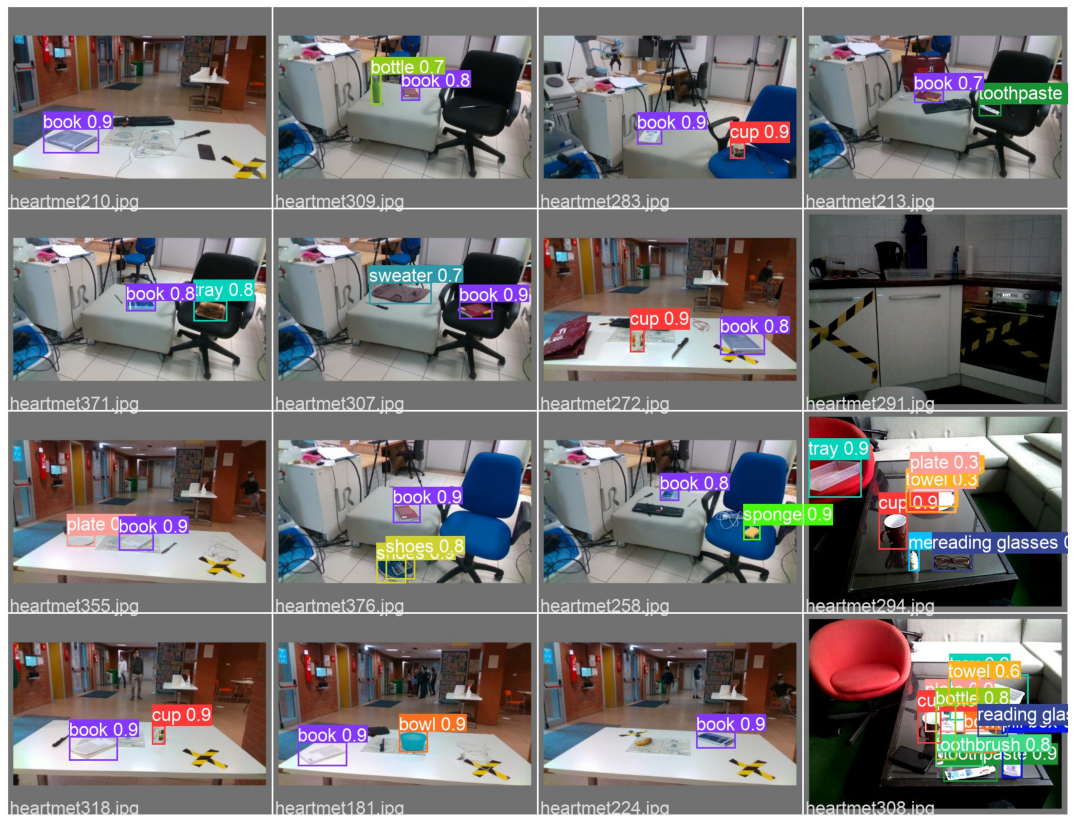

In [16]:
show_valid_results(RES_DIR)

### Inference
In this section, we will carry out inference on unseen images and videos from the internet. 

The images for inference are in the `inference_images` directory.

**To carry out inference on images, we just need to provide the directory path where all the images are stored, and inference will happen on all images automatically.**

In [17]:
on_single_image = False

if on_single_image:
    # Inference on single image
    IMAGE_INFER_DIR = inference(RES_DIR, '/home/jovyan/public/b_it_bot_work/2d_perception/extreme_all_20_obj.jpeg')
else:
    # Inference on images.
    IMAGE_INFER_DIR = inference(RES_DIR, '/home/jovyan/public/b_it_bot_work/2d_perception/inference_heartmet_set_2')


IMAGE_INFER_DIR

Current number of inference detection directories: 20
/home/jovyan/public/logs/yolo5/detect/inference_21
detect: weights=['/home/jovyan/public/logs/yolo5/train/results_34/weights/best.pt'], source=/home/jovyan/public/b_it_bot_work/2d_perception/inference_heartmet_set_2, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=/home/jovyan/public/logs/yolo5/detect/inference_21, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-381-g7ab1f50 Python-3.9.13 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)

Fusing layers... 
Model summary: 290 layers, 20917590 parameters, 0 gradients
image 1/26 /home/jovyan/public/b_it_bot_work/2d_perception/inference_heartmet_set_2/book_0000_01.jpg: 480x640 1 cup, 2 

'/home/jovyan/public/logs/yolo5/detect/inference_21'

In [ ]:
# IMAGE_INFER_DIR = '/home/jovyan/public/logs/yolo5/detect/inference_4'
visualize(IMAGE_INFER_DIR)

# Export model (.pt) to ONNX model (.onnx)
###### Reference: https://learnopencv.com/object-detection-using-yolov5-and-opencv-dnn-in-c-and-python/

In [ ]:
!python export.py --weights /home/jovyan/public/logs/yolo5/train/results_28/weights/best.pt --include onnx